# Environment Setting

Step 1: upload entire "Structure Product (combined ver.)" folder to google drive\
Step 2: run the first code box below to mount to your google drive\
Step 3: paste the google drive path to "filepath = " below\
Step 4: click "Run all" and find output in "Output.xslx" in google drive\

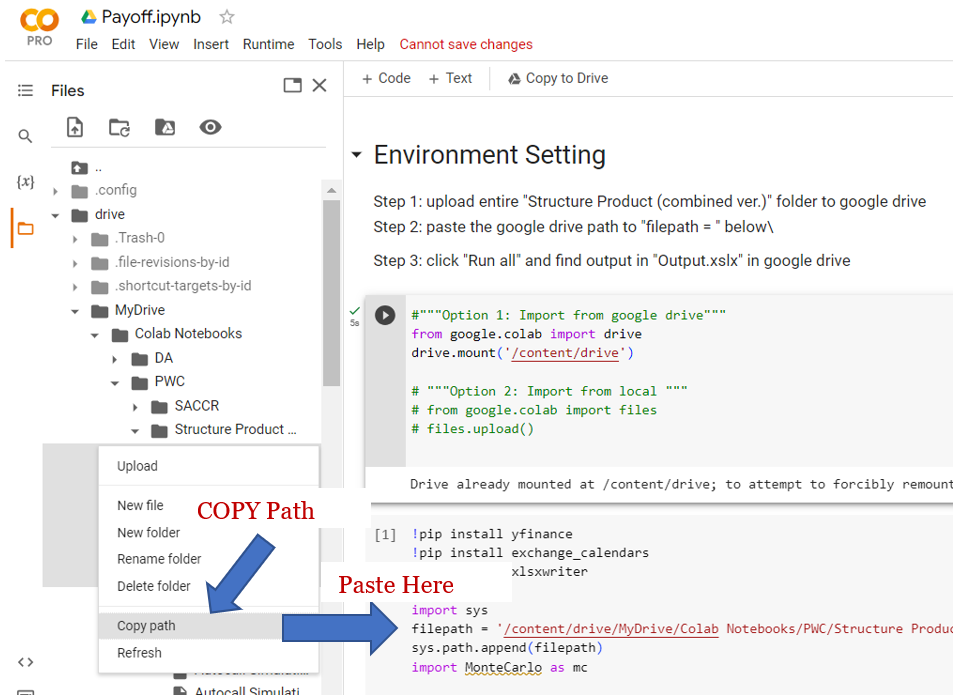

In [16]:

#"""Option 1: Import from google drive"""
### Mount to google drive ###
from google.colab import drive
drive.mount('/content/drive')

# """Option 2: Import from local """
# from google.colab import files
# files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!pip install yfinance
!pip install exchange_calendars
!pip install xlsxwriter

import sys
filepath = '/content/drive/MyDrive/Colab Notebooks/PWC/Structure Product Valuation/Structure Product (combined ver.)/'
sys.path.append(filepath)
import MonteCarlo as mc


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import exchange_calendars as xcals
import datetime as dt
import time
import openpyxl
import random
import os
from openpyxl.drawing.image import Image

# Build calender
xhkg = xcals.get_calendar("XHKG")

# Utility Functions


## Functions to Clean Input Data

In [20]:
def adjust_date(date,bd):
  """
  desc: If given date is not a scheduled trading date,
  return the next following scheduled trading day
  parameters:
    date: date time object to be pushed back
    bd: list contains all relavent business dates
  return: adjusted date time object
  """
  while date not in bd:
    date = date+dt.timedelta(days=1)
  return date


def reformat_date(input_type,input,return_type, adj_ref=None):
  """
  desc: reformat time range string and adjust date to
   valid business date, return the start and end date
  parameters:
    input_type: string in ['continurous','discrete']
    input: string contains date infomation
    return_type: "all" --- return all business dates in a period,
                "start_end" --- return the start and end dates
    adj_ref: list of dates as adjust reference
  return: list of date time object
  """

  if input_type == "continuous":
    temp =  input.replace(" ","").split('-')
    start = dt.datetime.strptime(temp[0],'%m/%d/%Y')
    end = dt.datetime.strptime(temp[1],'%m/%d/%Y')
    if return_type == 'all':
      date_list = xhkg.sessions_in_range(start,end)
    elif return_type == 'start_end':
      date_list = [start,end]

  elif input_type == 'discrete':
    try:
      input = input.replace(" ","").split(',')
      date_list = [adjust_date(dt.datetime.strptime(i,'%m/%d/%Y'),adj_ref) for i in input]
    except:
      date_list = [adjust_date(input,adj_ref)]
  else:
    date_list = pd.NA

  return date_list

def check_input_number(input,input_name, min, max= 10000, default=None):
  if default != None and pd.isna(input):
    input = default
  elif  input > max or input < min:
    print("Error: the", input_name," value is not within permitted range (min..max)")
  return input

def clean_contract(note):
  """
  desc: clean input data
  note: dictionary contain contracts details
  return: cleaned dictionary
  """

  note['tickers'] = note['tickers'].replace(" ","").split(',')

  note['autocall_barrier'] = check_input_number(note['autocall_barrier'],'autocall_barrier', 0, 10000)
  # 1. the value of reference barrier should be smaller than autocall barrier
  # 2. the value of kick barrier should be smaller than reference barrier
  # 3. set default value of reference and kick barrier to 0
  note['ref_barrier'] = check_input_number(note['ref_barrier'],'ref_barrier', 0, note['autocall_barrier'], default=0)
  note['kick_barrier'] = check_input_number(note['kick_barrier'],'kick_barrier', 0, note['ref_barrier'], default=0)

  # 1. set default value of fixed_coupon_rate to 0
  # 2. set default value of autocall_coupon to fixed_coupon_rate
  note['fixed_coupon_rate'] = check_input_number(note['fixed_coupon_rate'],'fixed_coupon_rate', 0, 100, default=0)
  note['autocall_coupon'] = check_input_number(note['autocall_coupon'],'autocall_coupon', 0, 100, default= note['fixed_coupon_rate'])

  # Business days in the range
  bd = xhkg.sessions_in_range(note['start_date'],note['maturity_date'])
  # Adjust maturity date if the inputted maturity date is not a business day
  if note['maturity_date'] not in bd:
    temp_bd =xhkg.sessions_in_range(note['start_date'], note['maturity_date']+dt.timedelta(5))
    note['maturity_date']  = adjust_date(note['maturity_date'],temp_bd)
    bd = xhkg.sessions_in_range(note['start_date'], note['maturity_date'])
  # Adjust start date if the inputted start date is not a business day
  if note['start_date'] not in bd:
    note['start_date']  = bd[0]
  note['bd'] = bd

  # Reformat & adjust call observation dates
  try:
    note['call_obs_date'] = reformat_date(note['call_obs_type'],note['call_obs_date'],return_type = 'all', adj_ref = bd)
  except:
    print("Invalid call_obs_date")

  # Reformat and adjust kick observation dates
  try:
      note['kick_obs_date'] = reformat_date(note['kick_obs_type'],note['kick_obs_date'],return_type = 'all', adj_ref = bd)
  except:
      print("Invalid kick_obs_date")

  # Reformat historical reference period
  try:
    note['his_ref_period'] = reformat_date('continuous',note['his_ref_period'],return_type = 'start_end')
  except:
    print("Invalid his_ref_period")
  return note


## Functions to Process Simulated Paths

In [21]:
def get_autocall_coupon_days(record,n_pass,call_obs_list,start_date):
  call_coupon_days = []
  for i in range(record.shape[1]):
    call_idx = np.where(record[:,i]==n_pass)[0]
    if call_idx.size != 0:
      first = call_idx[0]
      coupon_cal_days = (call_obs_list[first]-start_date).days
      call_coupon_days.append(coupon_cal_days)
    else:
      call_coupon_days.append(0)
  return call_coupon_days


def build_barrier_record(n_stock,barrier,obs_date,simu_df,bd,less_than=False):
  idx_list = [] #observation date index in simulated dataframe
  for d in obs_date:
    idx_list.append(bd.get_loc(d))
  if n_stock == 1 :
    record = simu_df[idx_list,:]>barrier if less_than== False else simu_df[idx_list,:]<barrier
  else:
    record = np.empty((n_stock,len(obs_date),simu_df.shape[2]))
    for s in range(n_stock):
      record[s,:,:] = simu_df[s,idx_list,:]>barrier[s] if less_than== False else simu_df[s,idx_list,:]<barrier[s]
  return record

## Functions to Get Coupon Day Counts for Different Scenarios

In [22]:
def get_autocall_coupon_array(n_stock,note,S0,simu_df,autocall_record):
  """
  Check if autocall event occured
  Calculate autocall coupon day counts
  """

  # if not pd.isna(note['autocall_barrier']):
  #   call_price = (S0 * note['autocall_barrier']).values[0] #call barrier price
  #   autocall_record = build_barrier_record(n_stock,call_price,note['call_obs_date'],simu_df,note['bd'])

  if n_stock == 1:
    # Univariate underlying
    call_coupon_days = get_autocall_coupon_days(autocall_record,1,note['call_obs_date'],note['start_date'])

  elif n_stock > 1:
    # Multivariate underlying

    if pd.isna(note['multi_call_condition']) or note['multi_call_condition'] == "all" :
      if note['call_memory(for all cond.)']=='no':
        # autocall only if ALL underlying stocks pass autocall barrier on an observation date
        temp = autocall_record.sum(axis = 0)
        call_coupon_days = get_autocall_coupon_days(temp,2,note['call_obs_date'],note['start_date'])
      elif note['call_memory(for all cond.)']=='yes':
        # autocall if ALL underlying stock has ever passed autocall barrier on any observation dates
        temp = []
        for s in range(n_stock):
          temp.append(get_autocall_coupon_days(autocall_record[s,:,:],1,note['call_obs_date'],note['start_date']))
        temp = np.array(temp)
        call_coupon_days = temp.max(axis=0) # exit when all the underlying stocks have ever pass autocall barrier
        no_call_idx = np.where(temp.min(axis=0)==0) #no autocall if any underlying stock has not pass autocall barrier
        call_coupon_days[no_call_idx] = 0

    elif note['multi_call_condition'] == "any":
      # autocall if ANY underlying stock passed autocall barrier on any observation dates
      temp = []
      for s in range(n_stock):
        temp.append(get_autocall_coupon_days(autocall_record[s,:,:],1,note['call_obs_date'],note['start_date']))
      temp = np.array(temp)
      call_coupon_days = temp.min(axis=0) # exit when ANY underlying stocks pass autocall barrier
      zero_idx = np.where(call_coupon_days==0)
      call_coupon_days[zero_idx] = temp[:,zero_idx].max(axis=0)

  return np.asarray(call_coupon_days)


def get_fixed_coupon_arr(call_coupon_days,n_stock,n_simulation, note,S0 ):
  """
  for simulation paths that no autocall event occured during the call observation period (i.e. call_coupon_days = 0),
  contract continue till maturity -> earn fixed coupon rate

  Profit and loss at maturity:
    Situation 1: obtain fixed coupon rate
    Situation 2: obtain fixed coupon rate + buy worst prefroming stock at reference price

  Calculate fixed coupon days count
  """

  no_call_idx = np.where(call_coupon_days == 0)

  days_til_maturity = (note['maturity_date']-note['start_date']).days
  fixed_coupon_days = np.zeros(n_simulation)
  fixed_coupon_days[no_call_idx] = days_til_maturity

  return np.asarray(fixed_coupon_days)

## Function to Calculate P&L


### Calculate Coupon Amount

In [23]:
def cal_coupon_payment(coupon_days,day_count_basis,coupon_rate,rf,notional,discount = True):

  payment = coupon_days/day_count_basis * notional * coupon_rate
  if discount:
    dis_rate = mc.discount_rate(coupon_days,rf,day_count_basis)
    return payment* dis_rate
  else:
    return payment

### Loss at Maturity (for contract with reference barrier at maturity)

In [24]:
def cal_loss_at_maturity(call_coupon_days,n_stock,n_simulation, note,S0,simu_df ):
  """
  for simulation paths that no autocall event occured during the call observation period (i.e. call_coupon_days = 0),
  contract continue till maturity -> earn fixed coupon rate

  Profit and loss at maturity:
    Situation 1: obtain fixed coupon rate
    Situation 2: obtain fixed coupon rate + buy worst prefroming stock at reference price
      Conditions for situation 2: a. Reference barrier exist
                                  b. Close price at maturity date lower than reference price
                                  c. (if kick barrier exist) below kick barrier at kick observation date

  Calculate payoff at maturity
  """

  if note['kick_barrier'] != 0:
    kick_price = (S0 * note['kick_barrier']).values[0] #kick barrier price
    kick_record = build_barrier_record(n_stock,kick_price,note['kick_obs_date'],simu_df,note['bd'],less_than= True)

  ref_price = (S0 * note['ref_barrier']).values[0]

  no_call_idx = np.where(call_coupon_days == 0)
  loss = np.zeros(n_simulation)

  #calculate loss (buy worst performing equity at reference price)
  if n_stock == 1:
    # Univariate underlying
    if note['ref_barrier'] > 0:

      maturity_price = simu_df[-1,:]
      buy_at_ref = np.zeros(n_simulation)
      buy_at_ref[no_call_idx] = (maturity_price < ref_price)[no_call_idx]
      # when close price < ref_barrier, buy worst performing stock at reference price
      # however if kick barrier exist but never pass barrier on kick observation dates -> no need to buy stock at referencce price
      if note['kick_barrier'] > 0:
        #kick_record: 1 -- kicked 0 -- never kick
        buy_at_ref = kick_record * buy_at_ref

      loss_amount = note['notional_amount'] * (1- maturity_price/ref_price)
      loss = loss_amount * buy_at_ref

  elif n_stock > 1:
    # Multivariate underlying
    if note['ref_barrier'] > 0:
      maturity_price = simu_df[:,-1,:]
      worst_performing_loss_ratio = (maturity_price/np.repeat(ref_price,n_simulation).reshape(n_stock,n_simulation)).min(axis=0)
      buy_at_ref = np.zeros(n_simulation)
      # when ANY underlying equity closing price < ref_barrier, buy worst performing stock at reference price
      buy_at_ref[no_call_idx] = (worst_performing_loss_ratio < 1)[no_call_idx]
      # however if kick barrier exist but never pass barrier on kick observation dates -> no need to buy stock at referencce price

      if note['kick_barrier'] > 0:
        #kick_occured: 1 -- kicked  (* below_ref = buy_at_ref)
        #              0 -- never kick (* below_ref = not buy_at_ref)
        kick_occured= kick_record.sum(axis = 0).sum(axis=0)>0
        buy_at_ref = kick_occured * buy_at_ref

      loss_amount = note['notional_amount'] * (1- worst_performing_loss_ratio)
      loss = loss_amount * buy_at_ref

  return np.asarray(loss)


In [25]:
def get_simulated_df(note,n_simulation,verbose=True):

  his_price = mc.get_stock_price(note['tickers'],note['his_ref_period'][0],note['his_ref_period'][1])
  S0 = mc.get_stock_price(note['tickers'],note['start_date'],note['start_date']+dt.timedelta(days=1))
  T = len(note['bd']) #length of simulation

  # Run simulation
  rt_0 = time.time()
  n_stock = S0.shape[1]

  if n_stock == 1:
    simu_df = mc.single_asset_simulation(T,his_price,note['risk_free'],n_simulation,S0)
  elif n_stock > 1:
    simu_df = mc.multi_assets_simulation(T,his_price,note['risk_free'],n_simulation,S0)

  if verbose:
    print("Runtime for", n_simulation, "simulations is: ", time.time()-rt_0)

  return S0, simu_df, n_stock, his_price

## Functions for Output

### Make Output DataFrame

In [26]:
def period_to_string(start, end):
  return start.strftime('%m/%d/%Y') + "-" + end.strftime('%m/%d/%Y')

In [27]:
def fill_summary_row(note, output_summary,i):

  output_summary.loc[i,["contract name","n_simulation","risk free rate","notional amount"]] =[note[key] \
            for key in ["contract_name","n_simulation","risk_free","notional_amount"]]
  output_summary.at[i,"tickers"]= note['tickers']
  output_summary.at[i,"reference period"] =[i.strftime('%m/%d/%Y') for i in note['his_ref_period']]

  output_summary.at[i,"historical volatility"]= [ round(i, 3) for i in mc.get_volatility(his_price)]
  if len(simu_df.shape) == 2:

    output_summary.at[i,"simulated avg volatility"] = [round(mc.get_volatility(simu_df).mean(),3)]
  else:

    output_summary.at[i,"simulated avg volatility"] = [round(mc.get_volatility(simu_df[i,:,:]).mean(),3) for i in range(simu_df.shape[0])]

  pnl_list = [pnl.mean(),pnl.max(),pnl.min()]
  output_summary.loc[i,["potential P&L","Max P&L","Min P&L"]] =[round(i,3) for i in pnl_list]
  output_summary.loc[i,["potential P&L(%)","Max P&L(%)","Min P&L(%)"]] =[round(r*100/note['notional_amount'],3) for r in pnl_list]
  output_summary.loc[i,"total coupon earned"] =round(coupon_earned.mean(),3)
  output_summary.loc[i,"simulation time"] =dt.datetime.now()
  return output_summary

In [28]:
def create_info_df(note):

  names = ["Underlying Equity","Contract Period","Notional Amount",\
          "Autocall Observation Date","Autocall Barrier","Autocall Coupon",\
          "Fixed Coupon","Floating Rate","Kick Observation Date","Kick Barrier","Reference Barrier",\
          "Call Condition(for multivariate Underlying)","Call Memory(for multivariate Underlying)"]
  contract_info_df = pd.DataFrame(columns = ["Info"],index = names)
  info_keys = ["tickers","notional_amount","autocall_barrier","autocall_coupon","fixed_coupon_rate","floating_rate","kick_barrier","ref_barrier","multi_call_condition","call_memory(for all cond.)"]
  contract_info_df.loc[["Underlying Equity","Notional Amount","Autocall Barrier",\
                      "Autocall Coupon","Fixed Coupon","Floating Rate","Kick Barrier","Reference Barrier",\
        "Call Condition(for multivariate Underlying)","Call Memory(for multivariate Underlying)"],"Info"]\
                   = [note[key] for key in info_keys]
  contract_info_df.loc["Contract Period","Info"]=period_to_string(note["start_date"],note["maturity_date"])

  if note['call_obs_type'] == "discrete":
    contract_info_df.loc["Autocall Observation Date","Info"] = [i.strftime('%m/%d/%Y') for i in note["call_obs_date"] ]
  elif pd.isna( note['call_obs_type'] ):
    contract_info_df.loc["Autocall Observation Date","Info"] = "-"
  else:
    contract_info_df.loc["Autocall Observation Date","Info"] = period_to_string(note["call_obs_date"][0],note["call_obs_date"][-1])


  if note['kick_obs_type'] == "discrete" :
    contract_info_df.loc["Kick Observation Date","Info"] = [i.strftime('%m/%d/%Y') for i in note["kick_obs_date"] ]
  elif pd.isna( note['kick_obs_type']):
    contract_info_df.loc["Kick Observation Date","Info"] =  "-"
  else:
    contract_info_df.loc["Kick Observation Date","Info"] = period_to_string(note["kick_obs_date"][0],note["kick_obs_date"][-1])

  contract_info_df.loc[contract_info_df["Info"]==0,"Info"]="-"
  contract_info_df.loc[pd.isna(contract_info_df["Info"]==0),"Info"]="-"

  return contract_info_df

### Make Output Graph

In [29]:
def make_univariate_graph(note,his_price,simu_df):
  plt.figure(figsize=(10,9))
  plt.subplot(2,2,1)
  mc.print_stock_plot(note['tickers'],his_price,"Historical Stock Path")
  plt.xticks(rotation = 15)
  plt.subplot(2,2,2)
  final_price = simu_df[-1,:]
  plt.hist(final_price,bins =50,color = 'orange')
  plt.axvline(simu_df[0,0], label = "Initial Price", linestyle="--",color = 'k')
  plt.axvline(np.mean(final_price), label = "Mean Final Price", linestyle="--",color = 'r')
  plt.title("Stimulated Stock Price on Maturity Date")
  plt.legend()
  plt.subplot(2,2,3)
  plt.hist(pnl.T)
  plt.gca().set(title='P&L Frequency Histogram', ylabel='Frequency',xlabel='P&L');
  plt.subplot(2,2,4)
  simu_price_avg = np.mean(simu_df,axis = 1)
  mc.print_stock_plot(note['tickers'],simu_price_avg,"Simulated path (avg)")
  p1 = plt.savefig("myplot.png", dpi = 60)


  verti_line,verti_name= [],[]
  hori_line,hori_name= [],[]

  if note['call_obs_type'] == "continuous":
    verti_line= [note['bd'].get_loc(note['call_obs_date'][0]),note['bd'].get_loc(note['call_obs_date'][-1])]
    verti_name = ["call obs start","call obs end"]
  elif note['call_obs_type'] == "discrete":
    verti_line= [note['bd'].get_loc(note['call_obs_date'][i]) for i in range(len(note['call_obs_date']))]
    verti_name = ["call obs"]+[" "]*(len(note['call_obs_date'])-1)

  if note['kick_barrier'] > 0 :
    hori_line.append(simu_df[0,0] * note['kick_barrier'])
    hori_name.append("kick barrier")

  if note['autocall_barrier'] > 0 :
    hori_line.append(simu_df[0,0] * note['autocall_barrier'])
    hori_name.append("call barrier")

  if note['ref_barrier'] > 0 :
    hori_line.append(simu_df[0,0] * note['ref_barrier'])
    hori_name.append("ref barrier")


  # print randomly selected simulated paths
  plt.figure(figsize=(10,9))
  random_path = random.sample(range(n_simulation),4)
  for i in range(4):

    plt.subplot(2,2,i+1)

    mc.print_stock_plot(note['tickers'],simu_df[:,random_path[i]].T,\
                        "Randomly Selected Paths: No."+str(random_path[i]),\
                        hori_line = hori_line,hori_label = hori_name,\
                        verti_line = verti_line, verti_label = verti_name)
  p2 = plt.savefig("myplot2.png", dpi = 60)

  # call_price = (simu_df[0,0] * note['autocall_barrier'])
  # # print randomly selected simulated paths
  # plt.figure(figsize=(10,9))
  # random_path = random.sample(range(n_simulation),4)
  # for i in range(4):
  #   plt.subplot(2,2,i+1)
  #   mc.print_stock_plot(note['tickers'],simu_df[:,random_path[i]].T,\
  #                       "Randomly Selected Paths: No."+str(random_path[i]),\
  #                       hori_line = [call_price],hori_label = ['Autocall'])
  # p2 = plt.savefig("myplot2.png", dpi = 60)
  p1 = Image("myplot.png")
  p2 = Image("myplot2.png")

  return p1,p2

In [30]:
def make_multivariate_graph(note,his_price,simu_df):
  n_stock = simu_df.shape[0]
  # print plot
  plt.figure(figsize=(10,9))
  for i in range(n_stock):
    plt.subplot(2,n_stock,i+1)
    mc.print_stock_plot(note['tickers'][i],his_price.iloc[:,i],"Historical Stock Path")
    plt.xticks(rotation = 15)

  plt.subplot(2,n_stock,n_stock+1)
  plt.hist(pnl)
  plt.gca().set(title='P&L Histogram', ylabel='Frequency',xlabel='P&L');
  # plt.subplot(2,2,4)
  # plt.hist(pnl[pnl>0])
  # plt.gca().set(title='Profit Frequency Histogram', ylabel='Frequency',xlabel='Total Profit');
  p1 = plt.savefig("myplot.png", dpi = 60)

  # plt.figure(figsize=(4,4))
  # plt.hist(pnl)
  # plt.gca().set(title='P&L Histogram', ylabel='Frequency',xlabel='Total Loss');
  # p3 = plt.savefig("myplot3.png", dpi = 30)
  # print randomly selected simulated paths
  # call_price = simu_df[0,0,0] * info['call_rate']
  # kick_price = simu_df[0,0,0] * info['kick_rate']
  # ref_price = simu_df[0,0,0] * info['ref_rate']

  # plt.figure(figsize=(10,9))
  # random_path = random.sample(range(n_simulation),4)
  # for i in range(4):
  #   plt.subplot(2,2,i+1)
  #   mc.print_stock_plot(note['tickers'],simu_df[:,:,random_path[i]].T,\
  #                       "Randomly Selected Paths: No."+str(random_path[i]))#,\
  #                       # hori_line = [call_price,kick_price,ref_price],\
  #                       # hori_label = ['call barrier','kick barrier', 'reference price'])


  verti_line,verti_name= [],[]
  hori_line,hori_name= [],[]

  if note['call_obs_type'] == "continuous":
    verti_line= [note['bd'].get_loc(note['call_obs_date'][0]),note['bd'].get_loc(note['call_obs_date'][-1])]
    verti_name = ["call obs start","call obs end"]
  elif note['call_obs_type'] == "discrete":
    verti_line= [note['bd'].get_loc(note['call_obs_date'][i]) for i in range(len(note['call_obs_date']))]
    verti_name = ["call obs"]+[" "]*(len(note['call_obs_date'])-1)



  if note['kick_barrier'] > 0 :
    hori_line.append(simu_df[:,0,0] * note['kick_barrier'])
    hori_name.append("kick barrier")

  if note['autocall_barrier'] > 0 :
    hori_line.append(simu_df[:,0,0] * note['autocall_barrier'])
    hori_name.append("call barrier")

  if note['ref_barrier'] > 0 :
    hori_line.append(simu_df[:,0,0] * note['ref_barrier'])
    hori_name.append("ref barrier")


  plt.figure(figsize=(10,9))
  random_path = random.sample(range(n_simulation),4)
  k = 2* n_stock
  j=1
  for n in range(n_stock):
    for i in range( 2 ):

      plt.subplot(2,n_stock,j)
      mc.print_stock_plot(note['tickers'],simu_df[n,:,random_path[n]].T,\
                          "Randomly Selected Paths: No."+str(random_path[i]),
                          hori_line = np.array(hori_line)[:,n].tolist(), hori_label = hori_name,\
                          verti_line = verti_line, verti_label = verti_name)
      j+=1


  p2 = plt.savefig("myplot2.png", dpi = 60)
  p1 = Image("myplot.png")
  p2 = Image("myplot2.png")
  # p3 = Image("myplot3.png")
  return p1,p2

# Calculate Final Payoff

In [31]:
def final_payoff(note,n_simulation,simu_df):

  if not pd.isna(note['autocall_barrier']):
    call_price = (S0 * note['autocall_barrier']).values[0] #call barrier price
    autocall_record = build_barrier_record(n_stock,call_price,note['call_obs_date'],simu_df,note['bd'])

    # get autocalled paths coupon days counts
    autocall_coupon_arr = get_autocall_coupon_array(n_stock,note,S0,simu_df,autocall_record)
    # calculate autocalled paths coupon gains
    autocall_coupon_profit = cal_coupon_payment(autocall_coupon_arr,note['day_count_basis'],note['autocall_coupon'],note['risk_free'],note['notional_amount'],discount = True)

  else:
    autocall_coupon_arr = np.zeros(n_simulation)
    autocall_coupon_profit = np.zeros(n_simulation)


  # calculate no autocall paths fixed coupon day counts
  fixed_coupon_arr = get_fixed_coupon_arr(autocall_coupon_arr,n_stock,n_simulation, note,S0 )
  maturity_coupon_profit = cal_coupon_payment(fixed_coupon_arr,note['day_count_basis'],note['fixed_coupon_rate'],note['risk_free'],note['notional_amount'],discount = True)

  # get no autocalled paths fixed coupon days counts and loss at maturity
  loss = cal_loss_at_maturity(autocall_coupon_arr,n_stock,n_simulation, note,S0,simu_df )
  # calculate coupon amount to pay counter party
  pay_counter = cal_coupon_payment(autocall_coupon_arr+ fixed_coupon_arr,note['day_count_basis'],note['floating_rate'],note['risk_free'],note['notional_amount'],discount = True)
  # final profit and loss
  pnl = autocall_coupon_profit + maturity_coupon_profit - loss - pay_counter
  #coupon earned
  coupon_earned = autocall_coupon_profit + maturity_coupon_profit

  return  pnl, coupon_earned

# Run Simulation and Evaluate Contract Price

## Read Input

Running: sea_1_2
Runtime for 10000 simulations is:  0.1970996856689453
Total processing time for 10000 simulations is:  0.4609353542327881
----------------------------------------------------------------------------------------------------
Running: bema_1_0
Runtime for 10000 simulations is:  9.80834412574768
Total processing time for 10000 simulations is:  10.539990186691284
----------------------------------------------------------------------------------------------------


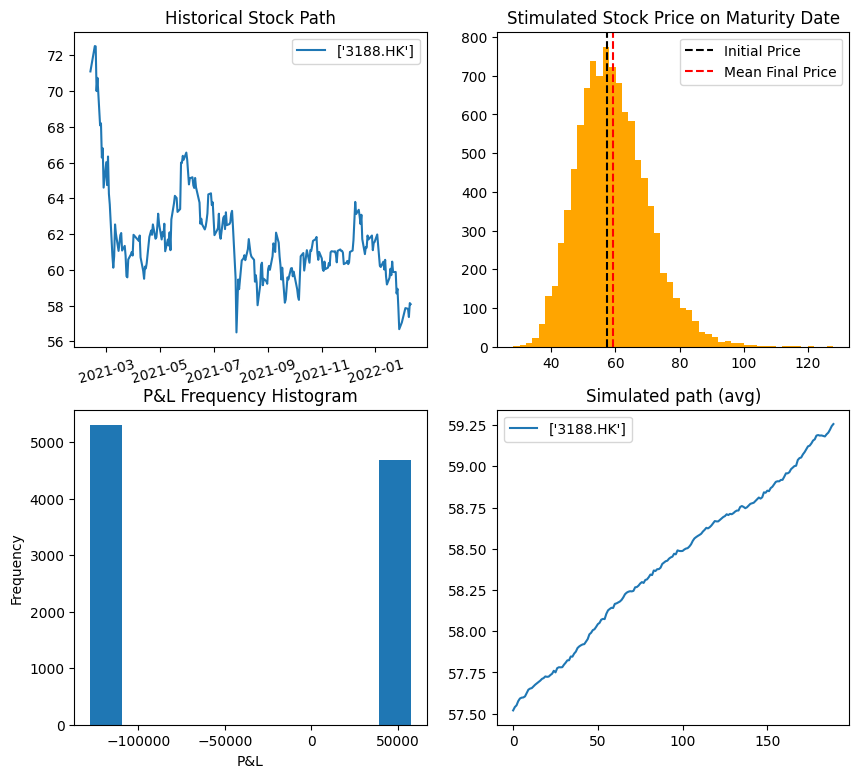

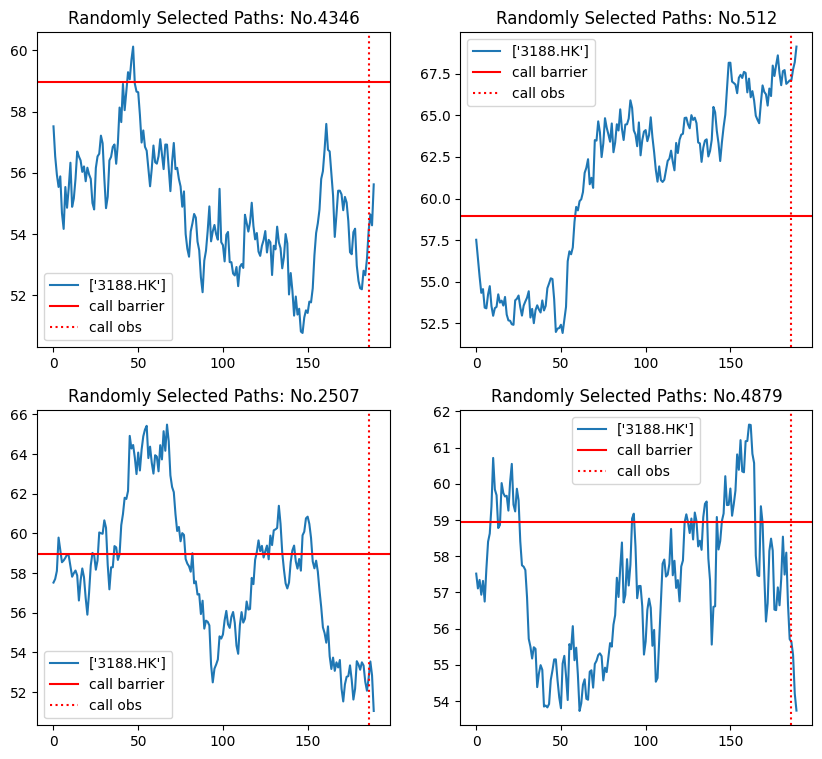

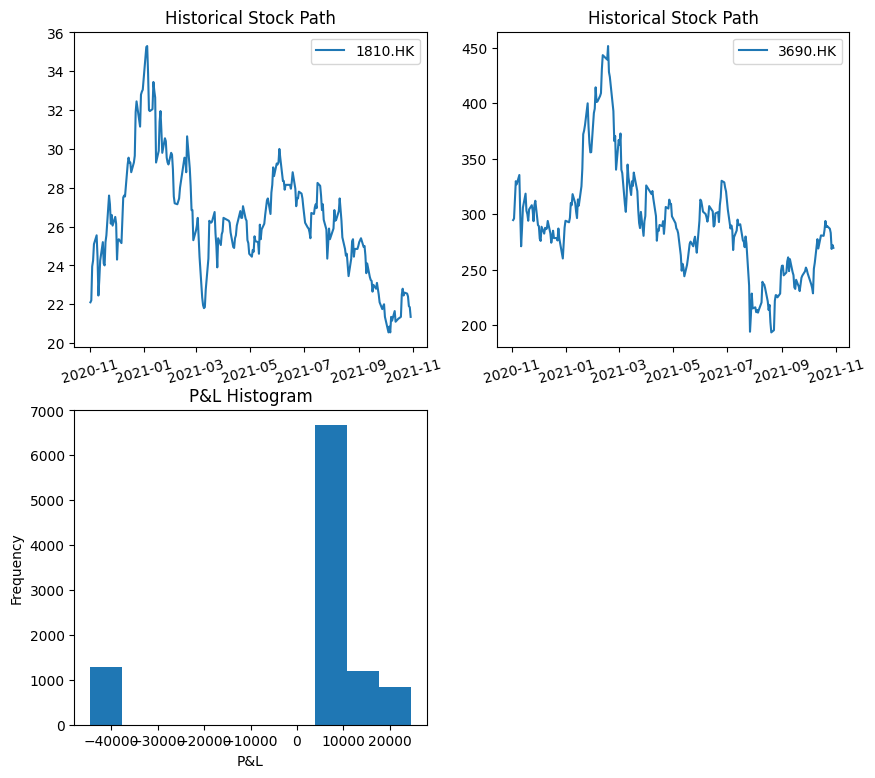

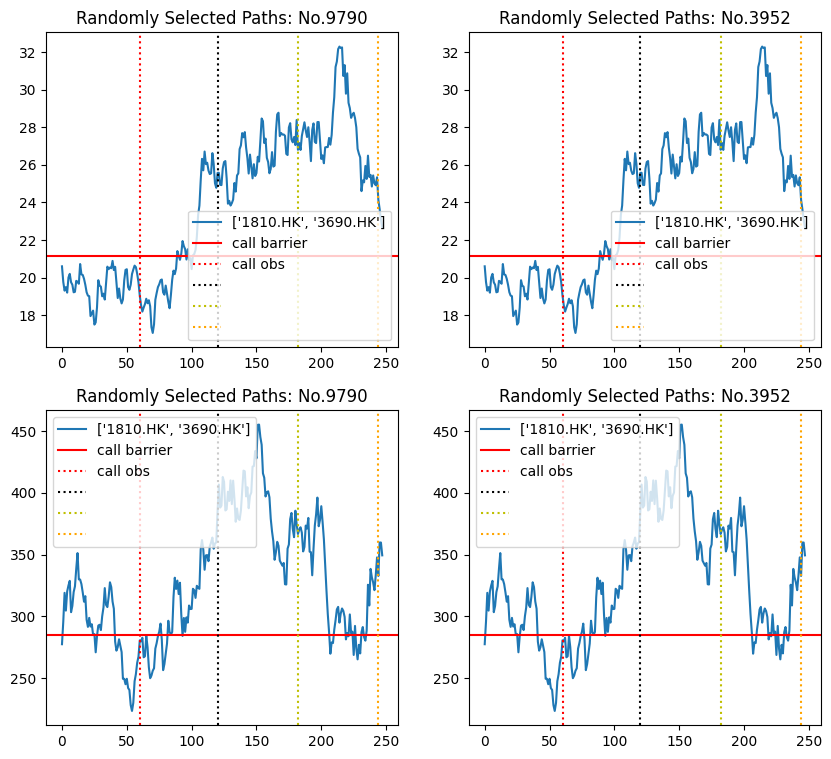

In [32]:
contract_df = pd.read_excel(filepath+'Input.xlsx',sheet_name='Contract',skiprows = 33,nrows = 20)
contract_dict = contract_df.to_dict('records')
new_contract = []

rerun_all = False # rerun all contracts in input file
verbose = True #control runtime printing

# Create output file if it is not in the path
output_filepath = filepath + 'Output.xlsx'
if not os.path.isfile(output_filepath):
  wb = openpyxl.Workbook()
  wb.save(output_filepath)

  column_name = ["contract name","tickers","n_simulation","reference period","risk free rate",\
               "historical volatility","simulated avg volatility", "notional amount",\
               "potential P&L",	"potential P&L(%)", "Max P&L","Max P&L(%)", "Min P&L",  "Min P&L(%)",\
               "total coupon earned", "simulation time"]
  output_summary = pd.DataFrame(columns = column_name)
  rerun_all = True
else:
  output_summary = pd.read_excel(filepath+'Output.xlsx',sheet_name='summary',index_col=None)
  output_summary = output_summary.drop(output_summary.columns[0],axis = 1)


for i in range(len(contract_dict)):
  if contract_dict[i]['Run'] == 'yes' or rerun_all:
    print("Running:",contract_dict[i]['contract_name'])
    # Clean inputted data
    contract = clean_contract(contract_dict[i])
    new_contract.append(contract)

    n_simulation = contract['n_simulation']

    rt_0 = time.time()
    S0, simu_df, n_stock, his_price = get_simulated_df(contract,n_simulation,verbose)
    pnl,coupon_earned = final_payoff(contract,n_simulation, simu_df)
    if verbose:
      print("Total processing time for", n_simulation, "simulations is: ", time.time()-rt_0)
    # print(pnl.sum()/n_simulation/contract['notional_amount'])

    output_summary = fill_summary_row(contract, output_summary,i)
    output_single = create_info_df(contract)

    simulated_outcome_df = output_summary.iloc[[i]].T
    simulated_outcome_df.columns = ['Info']
    single_outcome = pd.concat([output_single,simulated_outcome_df])

    if n_stock ==1:
      p1,p2 = make_univariate_graph(contract,his_price,simu_df)

    else:
      p1,p2 = make_multivariate_graph(contract,his_price,simu_df)



    wb = openpyxl.load_workbook(output_filepath)
    sheet_name = contract['contract_name']
    try:
      ws = wb[sheet_name]
    except KeyError:
      ws = wb.create_sheet(sheet_name)

    ws.add_image(p1,'D1')
    ws.add_image(p2,'D30')

    ws.column_dimensions['A'].width = 40
    ws.column_dimensions['B'].width = 30

    wb.save(output_filepath)

    with pd.ExcelWriter(output_filepath, engine = 'openpyxl',mode="a",if_sheet_exists="overlay") as writer:
      single_outcome.to_excel(writer,sheet_name = contract['contract_name'])


    print("-"*100)

with pd.ExcelWriter(output_filepath, engine = 'openpyxl',mode="a",if_sheet_exists="overlay") as writer:
    output_summary.to_excel(writer,sheet_name = "summary")
